# Tutorial on using the classes for transpiling DBQA strategies into various types of double-bracket rotations (DBRs)

## 1. VQE results are loaded
## 2. The GC3 DBR is shown using  the `GroupCommutatorIterationWithEvolutionOracles` class
### 3.1. It is shown how to perform more steps of the GCI. 
Using the class approach one can just change `mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced` to a different type and same code will run.

In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

## 1. Loading VQE results

In [2]:

qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/10q7l/sgd_10q_7l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)


[Qibo 0.2.9|INFO|2024-06-13 15:49:17]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-13 15:49:17]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [3]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {abs(ene1-target_energy)/abs(target_energy)}%.")

VQE energy is -14.856898957126564. 
The target energy is -15.276131122065795 which means the difference is 0.4192321649392312.
The relative difference is 0.02744360869838739%.


# 2. 3 GCI3 steps for fixed
$D= \sum_i B_i Z_i$
and Group commutator

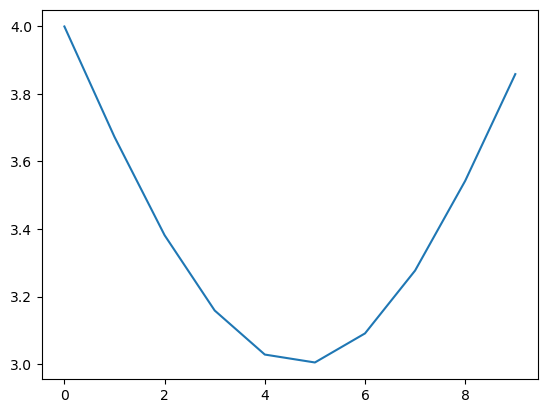

In [4]:
b_list = [4-np.sin(i/3) for i,x in enumerate(np.random.rand(10)) ]
                                  
plt.plot(b_list)

In [5]:


from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *


eo_xxz = XXZ_EvolutionOracle(nqubits, steps = 3, order = 2)

# implement the rotate by VQE on the level of circuits
fsoe  = VQERotatedEvolutionOracle(eo_xxz, vqe)


In [6]:

# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)


In [7]:
gci.print_gate_count_report()

The boosting circuit used 0 CNOT gates coming from compiled XXZ evolution and 70 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 0.0 and n_CZ/n_qubits = 7.0


In [8]:
# init the generator of the evolution,
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
eo_d = MagneticFieldEvolutionOracle(b_list,name = "D(linear)")
step,loss = gci.choose_step(d = eo_d,max_evals=34,step_min = 0.001,step_max = 0.003)
loss

-14.935556941199138

In [9]:
step

0.0024545454545454545

In [29]:
gci.loss(step, eo_d)

-14.801884982344752

In [11]:
gci(step, eo_d)
gci.print_gate_count_report()

The boosting circuit used 135 CNOT gates coming from compiled XXZ evolution and 210 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 13.5 and n_CZ/n_qubits = 21.0


In [30]:
gci.h_ref.expectation(gci.get_composed_circuit()().state())

-14.935556941199138

In [47]:
v1_circ = gci.get_composed_circuit()
fsoe2  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v1_circ.invert(), after_circuit=v1_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci2  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe2, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)


In [48]:

step,loss = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.0002,step_max = 0.007)
print(loss)
print(step)

-14.935584402651747
0.002466666666666667


In [51]:
gci2.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
step,loss = gci2.choose_step(d = eo_d,max_evals=34,step_min = 0.002,step_max = 0.007)
print(loss)
print(step)

-14.984427028066971
0.0051818181818181815


In [52]:
gci2(step, eo_d)
gci2.print_gate_count_report()

The boosting circuit used 945 CNOT gates coming from compiled XXZ evolution and 1050 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 94.5 and n_CZ/n_qubits = 105.0


In [66]:
v2_circ = gci2.get_composed_circuit()
fsoe3  = FrameShiftedEvolutionOracle(deepcopy(eo_xxz),before_circuit=v2_circ.invert(), after_circuit=v2_circ, name="fixing bug")
# init gci with the vqe-rotated hamiltonian
gci3  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe3, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_reduced)

In [67]:

step,loss = gci3.choose_step(d = eo_d,max_evals=34,step_min = 0.0002,step_max = 0.007)
print(loss)
print(step)

-15.010589667316292
0.002878787878787879


In [68]:
gci3.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
step,loss = gci3.choose_step(d = eo_d,max_evals=34,step_min = 0.002,step_max = 0.007)
print(loss)
print(step)

-15.032622863707562
0.006242424242424242


In [69]:
gci3(step, eo_d)
gci3.print_gate_count_report()

The boosting circuit used 4995 CNOT gates coming from compiled XXZ evolution and 5250 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 499.5 and n_CZ/n_qubits = 525.0


In [70]:
(loss-target_energy)/target_energy

-0.015940440443489932